# An End-to-End Project on Time Series Analysis and Forecasting with Python

### Source
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

### Load libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # 設定預設的畫圖 style

import itertools

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm

設定一些全域的畫圖相關的參數

In [0]:
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Load data

要讀取 Google Drive 裡面的檔案，要做這個步驟

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Superstore.xls")

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

#### 想要預測家具的銷售情形，所以先看看家具的欄位

In [7]:
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [0]:
furniture = df.loc[df['Category'] == 'Furniture'] # 注意這邊有用 .loc

In [9]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

所以家具有從 2014 年初到 2017 年底的銷售紀錄

### Data preprocessing

只想要用 `Order Date` 和 `Sales` 兩個欄位做分析，丟掉其他的欄位

In [10]:
cols = []
for col in furniture.columns:
  if col != 'Order Date' and col != 'Sales':
    cols.append(col)
print(cols)

['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']


In [0]:
furniture.drop(cols, axis=1, inplace=True)

In [0]:
furniture.sort_values('Order Date', inplace=True)

In [13]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [14]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

所以沒有 missing values

然後要把同一天的銷售部分加總起來

In [0]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [16]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


### Indexing with time series data

因為是時間序列，所以要把時間變成 index

In [0]:
furniture = furniture.set_index('Order Date')

In [18]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

只看每個月家具的平均銷售，並用每個月的第一天當該月的代表

In [0]:
y = furniture['Sales'].resample('MS').mean() # 用 M 的話會是月底，用 MS 才是月初

In [20]:
y['2017':] # 只看 2017 的

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

### Visualizing furniture sales time series data

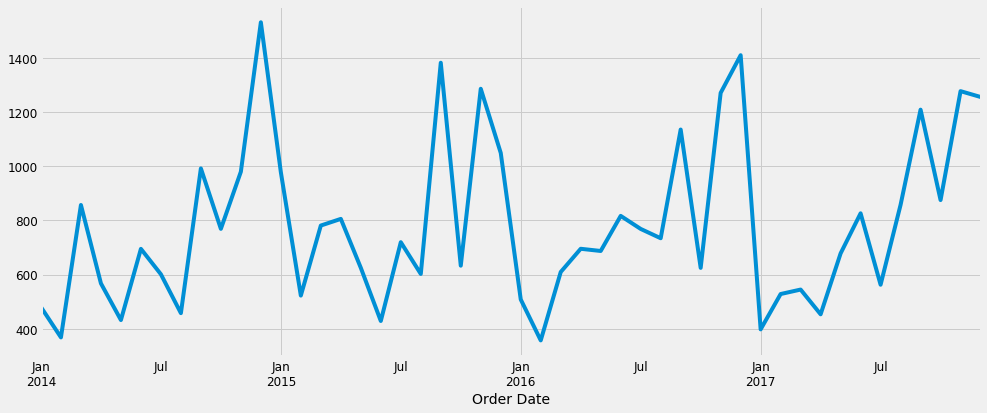

In [21]:
y.plot(figsize=(15, 6))
plt.show()

用 time series decomposition 把 time series 分成三個部分
* trend
* seasonality
* noice

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

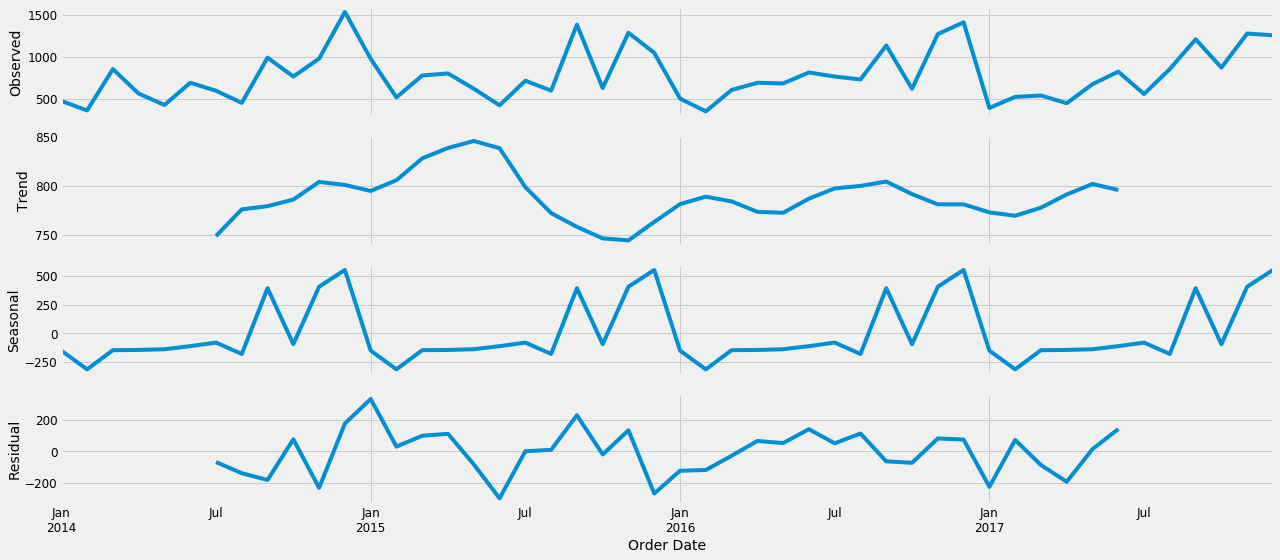

In [23]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Time series forecasting with ARIMA
* ARIMA: Autoregressive Integrated Moving Average
  * ARIMA method combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration
  * `from statsmodel.tsa.arima_model import ARIMA`
  * ARIMA(p, d, q)
  * p, d, q 三個參數分別代表  seasonality, trend, noise
  
* SARIMA: Seasonal Autoregressive Integrated Moving-Average
  * The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps. It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.
  * `from statsmodel.tsa.statespace.sarimax import SARIMAX`

* SARIMAX: Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors
  * The Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX) is an extension of the SARIMA model that also includes the modeling of exogenous variables. The SARIMAX method can also be used to model the subsumed models with exogenous variables, such as ARX, MAX, ARMAX, and ARIMAX
  * `from statsmodel.tsa.statespace.sarimax import SARIMAX`

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # 得到各種 p, d, q 的可能的組合
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [25]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [26]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


這裡的用意是產生 grid 所以可以用 grid search 來找出最佳的一組參數

In [27]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    
    try:
      mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                     seasonal_order=param_seasonal,
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
      results = mod.fit()
      print('ARIMA {}x{} 12 - AIC: {}'.format(param, param_seasonal, results.aic))
    except:
      continue

ARIMA (0, 0, 0)x(0, 0, 0, 12) 12 - AIC: 769.0817523205916
ARIMA (0, 0, 0)x(0, 0, 1, 12) 12 - AIC: 1526.6646435881128
ARIMA (0, 0, 0)x(0, 1, 0, 12) 12 - AIC: 477.71701309202774


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0)x(1, 0, 0, 12) 12 - AIC: 497.2314433418337
ARIMA (0, 0, 0)x(1, 0, 1, 12) 12 - AIC: 1402.3936867800505


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0)x(1, 1, 0, 12) 12 - AIC: 318.0047199116341
ARIMA (0, 0, 1)x(0, 0, 0, 12) 12 - AIC: 720.92522707581
ARIMA (0, 0, 1)x(0, 0, 1, 12) 12 - AIC: 2900.5279890044303
ARIMA (0, 0, 1)x(0, 1, 0, 12) 12 - AIC: 466.5607429809134


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1)x(1, 0, 0, 12) 12 - AIC: 499.5730681144165
ARIMA (0, 0, 1)x(1, 0, 1, 12) 12 - AIC: nan
ARIMA (0, 0, 1)x(1, 1, 0, 12) 12 - AIC: 319.98848769468657
ARIMA (0, 1, 0)x(0, 0, 0, 12) 12 - AIC: 677.894766843944
ARIMA (0, 1, 0)x(0, 0, 1, 12) 12 - AIC: 1420.8968510776567
ARIMA (0, 1, 0)x(0, 1, 0, 12) 12 - AIC: 486.6378567198382
ARIMA (0, 1, 0)x(1, 0, 0, 12) 12 - AIC: 497.78896630044073


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0)x(1, 0, 1, 12) 12 - AIC: 1283.8048690707233
ARIMA (0, 1, 0)x(1, 1, 0, 12) 12 - AIC: 319.7714068109211
ARIMA (0, 1, 1)x(0, 0, 0, 12) 12 - AIC: 649.9056176817081
ARIMA (0, 1, 1)x(0, 0, 1, 12) 12 - AIC: 2568.9604692368553
ARIMA (0, 1, 1)x(0, 1, 0, 12) 12 - AIC: 458.8705548482836
ARIMA (0, 1, 1)x(1, 0, 0, 12) 12 - AIC: 486.1832977442527
ARIMA (0, 1, 1)x(1, 0, 1, 12) 12 - AIC: 2982.3212858304873
ARIMA (0, 1, 1)x(1, 1, 0, 12) 12 - AIC: 310.7574368417338
ARIMA (1, 0, 0)x(0, 0, 0, 12) 12 - AIC: 692.1645522067712
ARIMA (1, 0, 0)x(0, 0, 1, 12) 12 - AIC: 1378.8837536991703
ARIMA (1, 0, 0)x(0, 1, 0, 12) 12 - AIC: 479.46321478521355


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0)x(1, 0, 0, 12) 12 - AIC: 480.9259367935194
ARIMA (1, 0, 0)x(1, 0, 1, 12) 12 - AIC: 1355.0241301172382
ARIMA (1, 0, 0)x(1, 1, 0, 12) 12 - AIC: 304.4664675084582
ARIMA (1, 0, 1)x(0, 0, 0, 12) 12 - AIC: 665.779444218597
ARIMA (1, 0, 1)x(0, 0, 1, 12) 12 - AIC: 3132.313062242019
ARIMA (1, 0, 1)x(0, 1, 0, 12) 12 - AIC: 468.36851958151317
ARIMA (1, 0, 1)x(1, 0, 0, 12) 12 - AIC: 482.5763323876961
ARIMA (1, 0, 1)x(1, 0, 1, 12) 12 - AIC: 2763.15984565311
ARIMA (1, 0, 1)x(1, 1, 0, 12) 12 - AIC: 306.01560021460404
ARIMA (1, 1, 0)x(0, 0, 0, 12) 12 - AIC: 671.2513547541902
ARIMA (1, 1, 0)x(0, 0, 1, 12) 12 - AIC: 1412.2716724812103
ARIMA (1, 1, 0)x(0, 1, 0, 12) 12 - AIC: 479.20034222811347
ARIMA (1, 1, 0)x(1, 0, 0, 12) 12 - AIC: 475.3403658784957


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0)x(1, 0, 1, 12) 12 - AIC: 1284.3702695020268
ARIMA (1, 1, 0)x(1, 1, 0, 12) 12 - AIC: 300.6270901345411
ARIMA (1, 1, 1)x(0, 0, 0, 12) 12 - AIC: 649.0318019835028
ARIMA (1, 1, 1)x(0, 0, 1, 12) 12 - AIC: 2726.367540279938
ARIMA (1, 1, 1)x(0, 1, 0, 12) 12 - AIC: 460.47626876100463
ARIMA (1, 1, 1)x(1, 0, 0, 12) 12 - AIC: 469.5250354660781
ARIMA (1, 1, 1)x(1, 0, 1, 12) 12 - AIC: 2625.787905160848
ARIMA (1, 1, 1)x(1, 1, 0, 12) 12 - AIC: 297.7875439531316


最好的結果是最後一列的 ARIMA (1, 1, 1)x(1, 1, 0, 12) 12 - AIC: 297.7875439531316

所以用這個參數的組合來做模型

### Fitting the ARIMA model

In [28]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


跑 model diagnostic 來看看是否有不正常的行為

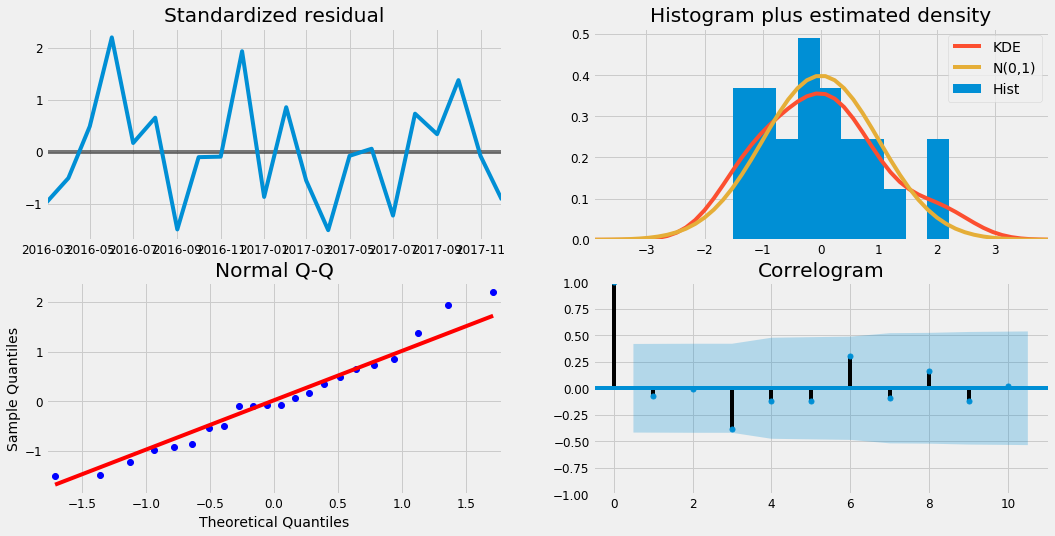

In [29]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

用 2017-01-01 之前的數據來預測 2017-01-01 之後的數據，並和真正的銷售做比較來驗證模型

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),
                              dynamic=False)
pred_ci = pred.conf_int() # 預測 2017-01-01 之後的結果，conf_int() 是 confidence interval

In [31]:
pred_ci # 是預測一個銷售的範圍

,lower Sales,upper Sales
Order Date,,
2017-01-01,204.675812,895.517719
2017-02-01,31.859939,721.913259
2017-03-01,296.215926,985.551779
2017-04-01,373.138295,1061.818593
2017-05-01,347.351888,1035.430861
2017-06-01,471.969439,1159.494854
2017-07-01,433.445540,1120.459689
2017-08-01,385.912693,1072.453200
2017-09-01,806.828457,1492.928938


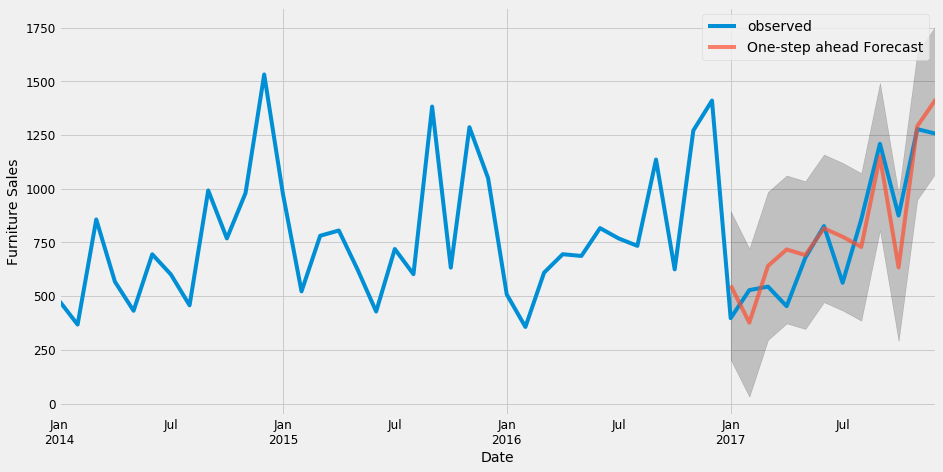

In [32]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [33]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


MSE 要越小越好

In [0]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


表示我們預測的結果和真正的銷售的差距會是在 151.64 個之間

### Producing and visualizing forecasts

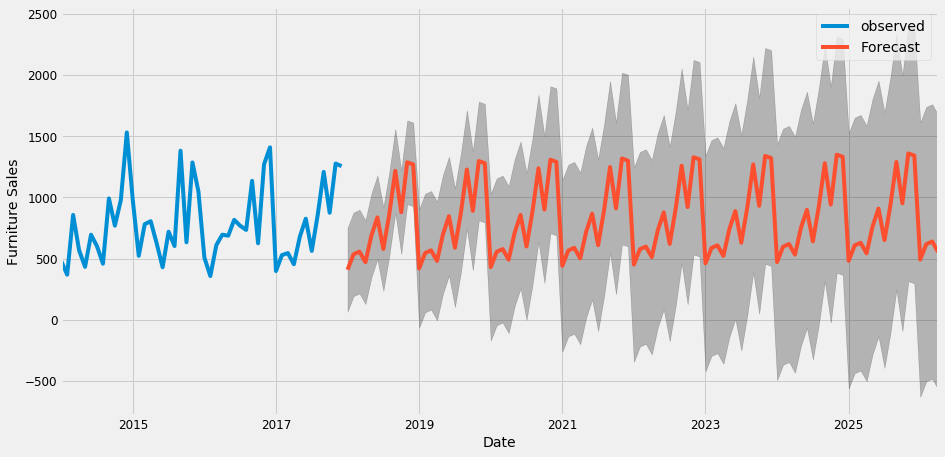

In [34]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

預測越後面的時間，預測的結果會越不準確，所以也反映在 confidence intervals 上，因此 band 越來越大

### Time series of furniture vs. office supplies

看看家具和辦公室文具兩者銷售之間的關係

In [0]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

In [36]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

### Data exploration

In [37]:
cols

['Row ID',
 'Order ID',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Quantity',
 'Discount',
 'Profit']

把不需要的欄位丟掉

In [0]:
furniture.drop(col, axis=1, inplace=True)
office.drop(col, axis=1, inplace=True)

In [0]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [0]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [0]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [0]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [0]:
furniture = pd.DataFrame({'Order Date':y_furniture.index,
                          'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date':y_office.index,
                       'Sales':y_office.values})

In [45]:
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x':'furniture_sales',
                      'Sales_y':'office_sales'},
             inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


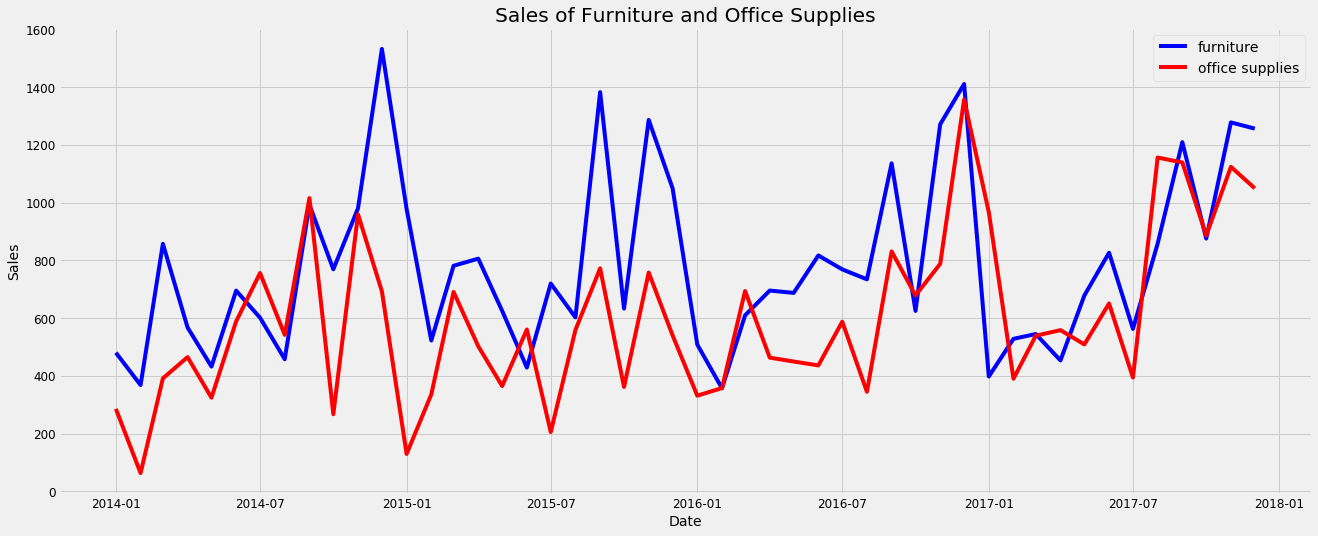

In [46]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label='furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label='office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend()

看看第一次辦公室文具銷售比家具還要好的日期

In [0]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

In [48]:
print(first_date)

2014-07-01 00:00:00


In [49]:
print('Office supplies first fitm produced higher sales than furniture is {}'.format(first_date.date()))

Office supplies first fitm produced higher sales than furniture is 2014-07-01


### Time series modeling with Prophet

FB 推出的 Prophet 用來做 time series analysis

In [51]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date':'ds', 'Sales':'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office = office.rename(columns={'Order Date':'ds', 'Sales':'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Furniture Sales')

<Figure size 1296x432 with 0 Axes>

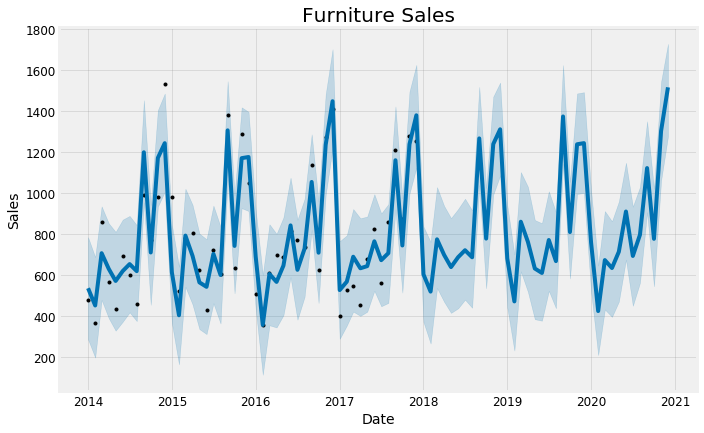

In [52]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')

Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1296x432 with 0 Axes>

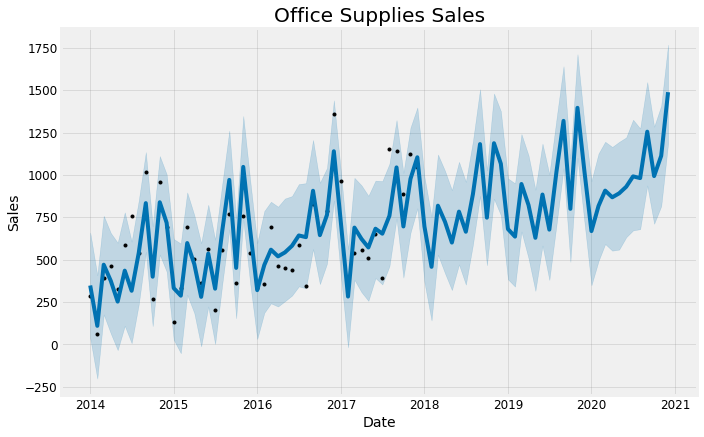

In [53]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel='Date', ylabel='Sales')
plt.title('Office Supplies Sales')

### Compare Forecasts

In [56]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

print(furniture_names)
print(office_names)

['furniture_ds', 'furniture_trend', 'furniture_yhat_lower', 'furniture_yhat_upper', 'furniture_trend_lower', 'furniture_trend_upper', 'furniture_additive_terms', 'furniture_additive_terms_lower', 'furniture_additive_terms_upper', 'furniture_yearly', 'furniture_yearly_lower', 'furniture_yearly_upper', 'furniture_multiplicative_terms', 'furniture_multiplicative_terms_lower', 'furniture_multiplicative_terms_upper', 'furniture_yhat']
['office_ds', 'office_trend', 'office_yhat_lower', 'office_yhat_upper', 'office_trend_lower', 'office_trend_upper', 'office_additive_terms', 'office_additive_terms_lower', 'office_additive_terms_upper', 'office_yearly', 'office_yearly_lower', 'office_yearly_upper', 'office_multiplicative_terms', 'office_multiplicative_terms_lower', 'office_multiplicative_terms_upper', 'office_yhat']


In [0]:
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [60]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast,
                    how='inner',
                    left_on='furniture_ds', right_on='office_ds')
forecast = forecast.rename(columns={'furniture_ds':'Date'}).drop('office_ds', axis=1)

forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,285.527471,784.239398,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,-190.685662,0.0,0.0,0.0,535.372051,487.530759,36.354441,659.806911,487.530759,487.530759,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,197.089728,687.081245,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,-276.377703,0.0,0.0,0.0,451.116320,494.918445,-202.217440,407.777181,494.918445,494.918445,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,478.345190,934.819679,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,-22.389755,0.0,0.0,0.0,706.401580,501.591193,176.198171,758.661254,501.591193,501.591193,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,389.223803,852.191128,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,-100.141158,0.0,0.0,0.0,630.086487,508.978878,63.869537,657.212194,508.978878,508.978878,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,328.275487,810.301724,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,-160.815662,0.0,0.0,0.0,570.801960,516.128251,-33.808075,600.014843,516.128251,516.128251,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


### Trend and Forecast Visualization

Text(0.5, 1.0, 'Furniture vs Office Supplies Sales Trend')

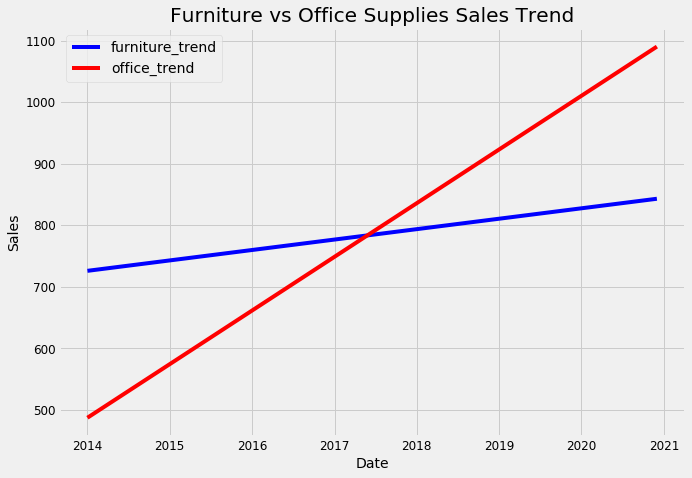

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies Sales Trend')

Text(0.5, 1.0, 'Furniture vs Office Supplies Estimate')

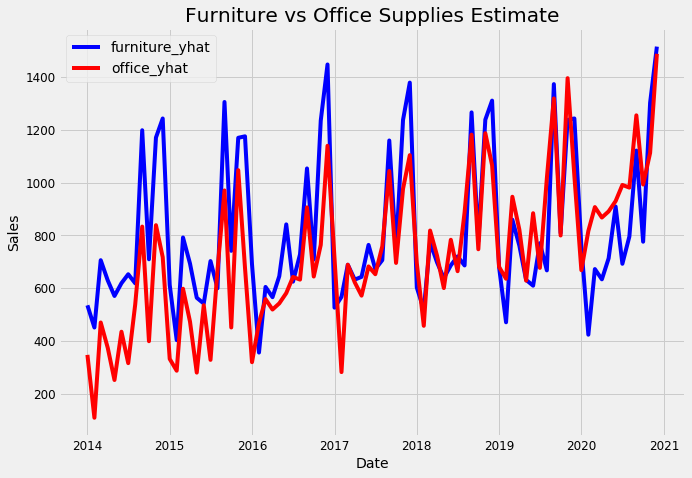

In [62]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies Estimate')

### Trends and Patterns

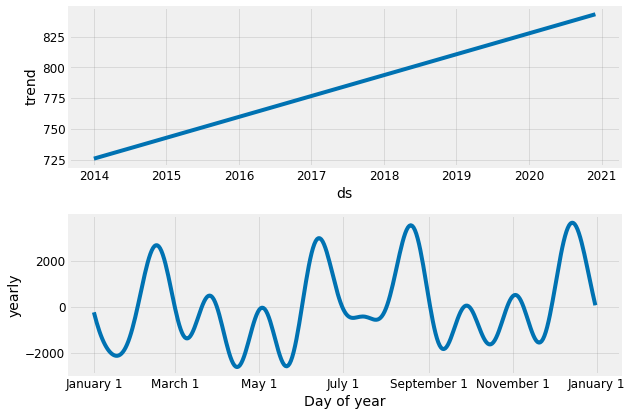

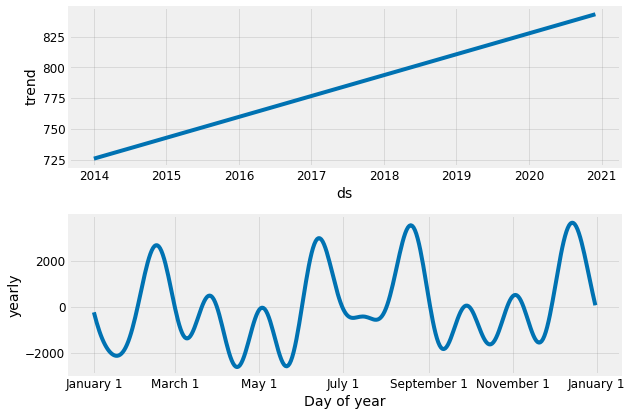

In [63]:
furniture_model.plot_components(furniture_forecast)

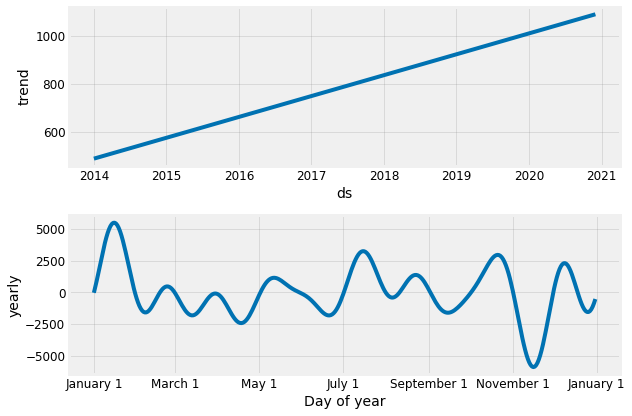

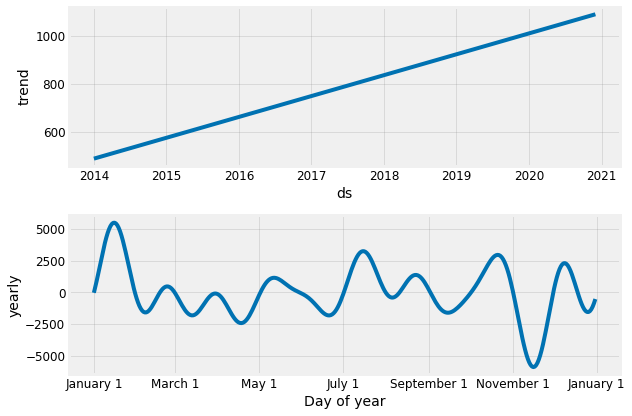

In [64]:
office_model.plot_components(office_forecast)